# Selecting A Location In Toronto For Starting An Indian Restaurant

## Introduction

### Background

#### A good restaurant is a good source of revenue. People go to restaurants not just to eat but also to hang-out with people, catch up on each other’s lives and have fun. A restaurant with consistently high standards can attain a sense of loyalty from customers, that with time, can result in a constant revenue stream. The Indian subcontinent has so many different cuisines that it is not too difficult to identify one that is not prevalent in that area and capitalize on it. Toronto is the most populous city in Canada and in 2016, 47% of its population was international.

### Problem

#### An Indian restaurant needs to be started in Toronto. There were six boroughs in Toronto out of which one needed to be identified for the location of the restaurant. The six boroughs were East York, Etobicoke, North York, Old City of Toronto, Scarborough and York. The analysis could then be drilled down to locate a neighborhood within the borough. 

### Target Audience

#### The target audience for this analysis is a restaurateur or an organization that is planning on starting am Indian restaurant in Toronto.

## The Data

#### The demographics of Toronto neighborhoods that was readily available in Wikipedia (https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods) was scraped for use as factors, that could help in identifying a suitable location for an Indian restaurant. A spreadsheet was created with coordinates for all the boroughs in Toronto for use in their visualization on a map. Foursquare API was used to extract the Indian restaurants in all the Toronto boroughs.

## Methodology

#### The model assumed 3 factors to influence the location of the restaurant. They were population, income and number of currently existing Indian restaurants in each borough. Number of currently existing restaurants was considered to be a negative factor in the model. All factors have an equal weight in the model.

#### Demographics of the Toronto neighborhoods was scraped from the Wikipedia page. Neighborhood, borough code, population and income were extracted and loaded into a dataframe. 

In [1]:
# Import all the necessary libraries
# Libraries for data analysis
import requests 
import pandas as pd 
import numpy as np

# Library to handle web-scraping
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Reading an excel file using Python 
import xlrd 

# Machine Learning and visualization packages
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium.plugins import HeatMap

print('Libraries imported')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported


In [2]:
# Web- scrape the demographic details of the Toronto neighborhoods
source= requests.get('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods').text
soup= BeautifulSoup(source, 'xml')

tb= soup.find('table',{'class':'wikitable sortable'})
list_can= []

for i in tb.find_all('tr'):
  list_can.append([j.text.strip() for j in (i.find_all('td'))])

# Remove the first element of the list which is empty and the second element that has the totals for the columns
list_can.pop(0)
list_can.pop(0)

['Toronto CMA Average',
 '',
 'All',
 '5,113,149',
 '5903.63',
 '866',
 '9.0',
 '40,704',
 '10.6',
 '11.4',
 '',
 '',
 '']

#### Population and income were considered positive factors for the analysis. This was because restaurant demand could increase with population and income. Since population and income had ranges of values that varied by orders of magnitude, each of these factors was scaled to have values between 0 and 1. 

In [3]:
# Create and populate a dataframe with Neighborhood, Population, Borough & Income in the list generated from the source
data=[]
columns= ['Neighborhood', 'Borough', 'Population', 'Income']
length= len(list_can)

for i in range(length):
    Neighborhood= list_can[i][0]
    Borough= list_can[i][1]
    Population= list_can[i][3]
    Income= list_can[i][7]
    # Create a dictionary of columns as keys and the 4 factors as values in the correct order
    neigh_bor_pop_inc = [Neighborhood, Borough, Population, Income]
    zipped = zip(columns, neigh_bor_pop_inc)
    a_dictionary = dict(zipped)
    data.append(a_dictionary)
    
#Convert list of dictionary values to a dataframe    
dfT= pd.DataFrame(data)

# Rename the Borough values to their actual names
dfT.Borough[dfT.Borough== 'OCoT']= 'Old City of Toronto'
dfT.Borough[dfT.Borough== 'S']= 'Scarborough'
dfT.Borough[dfT.Borough== 'NY']= 'North York'
dfT.Borough[dfT.Borough== 'E']= 'Etobicoke'
dfT.Borough[dfT.Borough== 'Y']= 'York'
dfT.Borough[dfT.Borough== 'EY']= 'East York'

# Sort and reset the index of the dataframe
dfT= dfT.sort_values('Borough')
dfT= dfT.reset_index(drop= True)

dfT

,Neighborhood,Borough,Population,Income
0,Old East York,East York,"52,220","33,172"
1,Crescent Town,East York,"8,157","23,021"
2,Governor's Bridge/Bennington Heights,East York,"2,112","129,904"
3,O'Connor–Parkview,East York,"17,740","33,517"
4,Thorncliffe Park,East York,"17,949","25,340"
...,...,...,...,...
169,Lambton,York,"9,654","30,920"
170,Mount Dennis,York,"21,284","23,910"
171,Silverthorn,York,"17,757","26,291"
172,Fairbank,York,"34,121","28,403"


In [4]:
# Create 2 dataframes to facilitate different calculations on each
df1= pd.DataFrame(columns= ['Borough', 'Population'])
df2= pd.DataFrame(columns= ['Borough', 'Income'])

# Sum the values in the Population column of the first sub- dataframe
df1['Borough']= dfT['Borough']
dfT['Population']= dfT['Population'].apply(lambda x: x.replace(',', ''))
dfT['Population']= pd.to_numeric(dfT['Population'])
df1['Population']= dfT['Population']
df1=df1.groupby('Borough').sum()

# Average the values in the Income column of the second sub- dataframe
df2['Borough']= dfT['Borough']
dfT['Income']= dfT['Income'].apply(lambda x: x.replace(',', ''))
dfT['Income']= pd.to_numeric(dfT['Income'])
df2['Income']= dfT['Income']
df2=df2.groupby('Borough').mean().astype(int)

# Merge the 2 dataframes
df= pd.merge(df1, df2, on='Borough')
df= df.sort_values('Borough')
df= df.reset_index()
pd.set_option('display.max_rows', 174)

df

,Borough,Population,Income
0,East York,112054,54604
1,Etobicoke,313772,43056
2,North York,621068,54389
3,Old City of Toronto,624910,58409
4,Scarborough,600715,30518
5,York,143255,38124


In [5]:
# Compile the coordinates for the 6 Toronto boroughs
coords = [['East York', 43.6912, -79.3417], 
        ['Etobicoke', 43.6205, -79.5132], 
        ['North York', 43.7615, -79.4111], 
        ['Old City of Toronto', 43.6516, -79.3705], 
        ['Scarborough', 43.7764, -79.2318], 
        ['York', 43.6957, -79.4504]]

# Create the dataFrame 
df_coord = pd.DataFrame(coords, columns = ['Borough', 'Latitude', 'Longitude']) 

df_coord

,Borough,Latitude,Longitude
0,East York,43.6912,-79.3417
1,Etobicoke,43.6205,-79.5132
2,North York,43.7615,-79.4111
3,Old City of Toronto,43.6516,-79.3705
4,Scarborough,43.7764,-79.2318
5,York,43.6957,-79.4504


In [6]:
# Add the Latitude and Longitude columns to the main dataframe
df['Latitude']= df_coord['Latitude'].values
df['Longitude']= df_coord['Longitude'].values

df

,Borough,Population,Income,Latitude,Longitude
0,East York,112054,54604,43.6912,-79.3417
1,Etobicoke,313772,43056,43.6205,-79.5132
2,North York,621068,54389,43.7615,-79.4111
3,Old City of Toronto,624910,58409,43.6516,-79.3705
4,Scarborough,600715,30518,43.7764,-79.2318
5,York,143255,38124,43.6957,-79.4504


#### Foursquare API was used to query for Indian restaurants within a distance of 1000 meters from the center of each of the 6 boroughs. 

In [7]:
# Supply the credentials to access the Foursquare API
df_auth = pd.read_excel (r'C:\Users\galax\Documents\Creds.xlsx')
CLIENT_ID= df_auth.iloc[0,0]
CLIENT_SECRET= df_auth.iloc[0,1]

In [8]:
SEARCH_QUERY= 'Indian'
RADIUS = 1000
VERSION='20200428'
LIMIT= '30'

In [9]:
LATITUDE= 43.6912
LONGITUDE= -79.3417
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.6912,-79.3417&v=20200428&query=Indian&radius=1000&limit=30'

In [10]:
# Extract Indian restaurants in East York
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_EY= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_EY['Borough']= 'East York'

In [11]:
LATITUDE= 43.6205
LONGITUDE= -79.5132

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.6205,-79.5132&v=20200428&query=Indian&radius=1000&limit=30'

In [12]:
# Extract Indian restaurants in Etobicoke
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_ET= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_ET['Borough']= 'Etobicoke'

In [13]:
LATITUDE= 43.7615
LONGITUDE= -79.4111
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.7615,-79.4111&v=20200428&query=Indian&radius=1000&limit=30'

In [14]:
# Extract Indian restaurants in North York
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_NY= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_NY['Borough']= 'North York'

In [15]:
LATITUDE= 43.6516
LONGITUDE= -79.3705
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.6516,-79.3705&v=20200428&query=Indian&radius=1000&limit=30'

In [16]:
# Extract Indian restaurants in Old City of Toronto
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_TO= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_TO['Borough']= 'Old City of Toronto'

In [17]:
LATITUDE= 43.7764
LONGITUDE= -79.2318
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.7764,-79.2318&v=20200428&query=Indian&radius=1000&limit=30'

In [18]:
# Extract Indian restaurants in Scarborough
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_SC= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_SC['Borough']= 'Scarborough'

In [19]:
LATITUDE= 43.6957
LONGITUDE= -79.4504
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, SEARCH_QUERY, RADIUS, LIMIT) 
url

'https://api.foursquare.com/v2/venues/search?client_id=2YM5GNXPLIV1E0UP1Z1J0PB4PGA5RZ4UA42RJT4H2SXEFT24&client_secret=KJ0WHHVKNVWWWRCOJMD0IEPFTRNE0KGBW3O3D1LC5BXUP2P2&ll=43.6957,-79.4504&v=20200428&query=Indian&radius=1000&limit=30'

In [20]:
# Extract Indian restaurants in York
results = requests.get(url).json()
results['response']['venues']

list1=[]
list2=[]
list3=[]
data= results['response']['venues']
length= len(data)
for i in range(length):
    list1.append(data[i]['name'])
    list2.append(data[i]['location']['lat'])
    list3.append(data[i]['location']['lng'])
df_R1= pd.DataFrame(list1, columns= ['Restaurant_Name'])
df_R2= pd.DataFrame(list2, columns= ['Latitude'])
df_R3= pd.DataFrame(list3, columns= ['Longitude'])

df_Y= pd.concat([df_R1, df_R2, df_R3], axis=1, sort=False)

df_Y['Borough']= 'York'

#### The FourSquare API query results were concatenated, resulting in a single dataframe.

In [21]:
# Concatenate the results from the 6 boroughs into one dataframe
df_IR= pd.concat([df_EY, df_ET, df_NY, df_SC, df_TO, df_Y], axis=0)
df_IR= df_IR.reset_index(drop= True)

df_IR

,Restaurant_Name,Latitude,Longitude,Borough
0,Maharani Indian Cuisine/The Queens Arms,43.622106,-79.521814,Etobicoke
1,Indian Crown,43.760076,-79.412153,North York
2,Butterchick Indian kitchen,43.762600,-79.410304,North York
3,Markham Danforth West Indian Food Market,43.767399,-79.228172,Scarborough
4,Spice Indian Bistro,43.653948,-79.369143,Old City of Toronto
5,Bindia Indian Bistro,43.648559,-79.371816,Old City of Toronto
6,Indian Bazaar,43.655653,-79.364153,Old City of Toronto
7,Indian Biriyani House,43.650050,-79.380662,Old City of Toronto
8,Chadani Indian Cuisine,43.649153,-79.374814,Old City of Toronto
9,Indian Flavour,43.655649,-79.384119,Old City of Toronto


#### 'Ontario Federation of Indigenous Friendship Centres' was removed from the dataframe since reserach showed that it was not an indian restaurant.

In [22]:
# Remove the incorrect row
df_IR= df_IR[df_IR['Restaurant_Name']!= 'Ontario Federation of Indigenous Friendship Centres']
df_IR= df_IR.reset_index(drop= True)

df_IR

,Restaurant_Name,Latitude,Longitude,Borough
0,Maharani Indian Cuisine/The Queens Arms,43.622106,-79.521814,Etobicoke
1,Indian Crown,43.760076,-79.412153,North York
2,Butterchick Indian kitchen,43.762600,-79.410304,North York
3,Markham Danforth West Indian Food Market,43.767399,-79.228172,Scarborough
4,Spice Indian Bistro,43.653948,-79.369143,Old City of Toronto
5,Bindia Indian Bistro,43.648559,-79.371816,Old City of Toronto
6,Indian Bazaar,43.655653,-79.364153,Old City of Toronto
7,Indian Biriyani House,43.650050,-79.380662,Old City of Toronto
8,Chadani Indian Cuisine,43.649153,-79.374814,Old City of Toronto
9,Indian Flavour,43.655649,-79.384119,Old City of Toronto


#### The number of restaurants was counted for each borough and stored in another dataframe. East York row was added to it even though it does not have any Indian restaurant since there were 2 other factors that could influence the restaurant location selection.

In [23]:
# Create a dataframe that has the restaurant count for each borough
df_IRC= df_IR
df_IRC= df_IRC.rename(columns={'Restaurant_Name':'Restaurant_Count'})
df_IRC=df_IRC.groupby('Borough')['Restaurant_Count'].count()
df_IRC= df_IRC.to_frame().reset_index()

# Add the East York row with zero restaurant count
df_IRC= df_IRC.append(pd.Series(['East York', '0'], index=df_IRC.columns), ignore_index=True)
df_IRC= df_IRC.sort_values('Borough')
df_IRC.set_index('Borough')
df_IRC= df_IRC.reset_index(drop= True)

df_IRC

,Borough,Restaurant_Count
0,East York,0
1,Etobicoke,1
2,North York,2
3,Old City of Toronto,11
4,Scarborough,1
5,York,2


In [24]:
# Create the dataset for the heatmap
df1=df[['Latitude','Longitude']]
lt= df1.values.tolist()
length=len(lt)
data1=[]

for i in range(length):
    data1.append(lt[i][0:2])

#### A heat map was created to visualize the centers of the boroughs.

In [25]:
map_toronto = folium.Map(location=[43.6532,-79.3832],zoom_start=10) 
for lat,lng,population,borough in zip(df['Latitude'],df['Longitude'],df['Population'], df['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.Marker((lat,lng), popup=label).add_to(map_toronto)
    HeatMap(data1, radius = 10, min_opacity= 0.7, gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(map_toronto)
    
map_toronto

#### K- means clustering with 5 clusters was run on the coordinates of all the restaurants with number of clusters representing the number of boroughs that had Indian restaurants. This was done for visualizing how close the clusters stayed within the boroughs.

In [26]:
# Create a new dataframe that is a copy of the dataframe that contains the restaurant names, their coordinates and their respective boroughs
tor_grp= df_IR

# Set the number of clusters to 5
k = 5

#Retain only the coordinate columns for the clustering
tor_grp_clustering = tor_grp.drop(['Restaurant_Name','Borough'], axis= 1)

#Run the k-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(tor_grp_clustering)
tor_grp.insert(0,'Cluster Labels',kmeans.labels_,True)

tor_grp

,Cluster Labels,Restaurant_Name,Latitude,Longitude,Borough
0,3,Maharani Indian Cuisine/The Queens Arms,43.622106,-79.521814,Etobicoke
1,1,Indian Crown,43.760076,-79.412153,North York
2,1,Butterchick Indian kitchen,43.762600,-79.410304,North York
3,2,Markham Danforth West Indian Food Market,43.767399,-79.228172,Scarborough
4,0,Spice Indian Bistro,43.653948,-79.369143,Old City of Toronto
5,0,Bindia Indian Bistro,43.648559,-79.371816,Old City of Toronto
6,0,Indian Bazaar,43.655653,-79.364153,Old City of Toronto
7,0,Indian Biriyani House,43.650050,-79.380662,Old City of Toronto
8,0,Chadani Indian Cuisine,43.649153,-79.374814,Old City of Toronto
9,0,Indian Flavour,43.655649,-79.384119,Old City of Toronto


In [27]:
# Create the map that is centered on Toronto
map_clusters = folium.Map(location=[43.6532,-79.3832],zoom_start=11.3)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, borough, cluster in zip(tor_grp['Latitude'], tor_grp['Longitude'], tor_grp['Borough'], tor_grp['Cluster Labels']):
    label = folium.Popup(str(borough) + 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### From the above map, it can be seen that K-means clustering did a fairly good job of clustering the restaurants into 5 clusters. This meant that the restaurants were not along the boundaries of the boroughs but around the centers.

#### A heat map was created to visualize the locations of all the restaurants. 

In [28]:
# Create a dataframe that is necessary for the heatmap
df2=df_IR[['Latitude','Longitude','Borough']]
lt= df2.values.tolist()
length=len(lt)
data2=[]
for i in range(length):
    data2.append(lt[i][0:2])

In [29]:
map_toronto1 = folium.Map(location=[43.6532,-79.3832],zoom_start=11) 
for lat,lng,borough in zip(df_IR['Latitude'],df_IR['Longitude'],df_IR['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.Marker((lat,lng), popup=label).add_to(map_toronto1)
    HeatMap(data2, radius = 10, min_opacity= 0.7, gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(map_toronto1)
    
map_toronto1

#### The borough of Old City of Toronto had many Indian restaurants close to each other, as can be seen in the map above. Number of restaurants was considered to be a negative factor. This was because the demand for the new restaurant could decrease with a large number of restaurants already in the borough. There could be a lower inclination to go to a new restaurant if there were others already serving the same cuisine in the borough. Since population, income and restaurant count had ranges of values that varied by orders of magnitude, each of these factors was scaled to have values between 0 and 1. Assuming the same weight across the 3 factors, and adopting a linear model, the total factor was the algebraic sum of the 3 factors. This total factor was the single value used to determine an ideal borough for a new Indian restaurant.

#### A bar graph was created to display the 3 factors for each borough, with number of restaurants used as a negative factor. 

In [30]:
# Create 2 dataframes for scaling the numeric column values
df_norm1=df[['Population','Income']]
df_norm2=df_IRC[['Restaurant_Count']].astype(int)

# Scale all column values such that every value is between 0- 1
df_normA = (df_norm1 - df_norm1.min()) / (df_norm1.max() - df_norm1.min())
df_normB = (df_norm2 - df_norm2.min()) / (df_norm2.max() - df_norm2.min())

df_norm= pd.concat([df['Borough'], df_normA, df_normB], axis=1)

df_norm

,Borough,Population,Income,Restaurant_Count
0,East York,0.000000,0.863576,0.000000
1,Etobicoke,0.393323,0.449536,0.090909
2,North York,0.992509,0.855867,0.181818
3,Old City of Toronto,1.000000,1.000000,1.000000
4,Scarborough,0.952823,0.000000,0.090909
5,York,0.060838,0.272704,0.181818


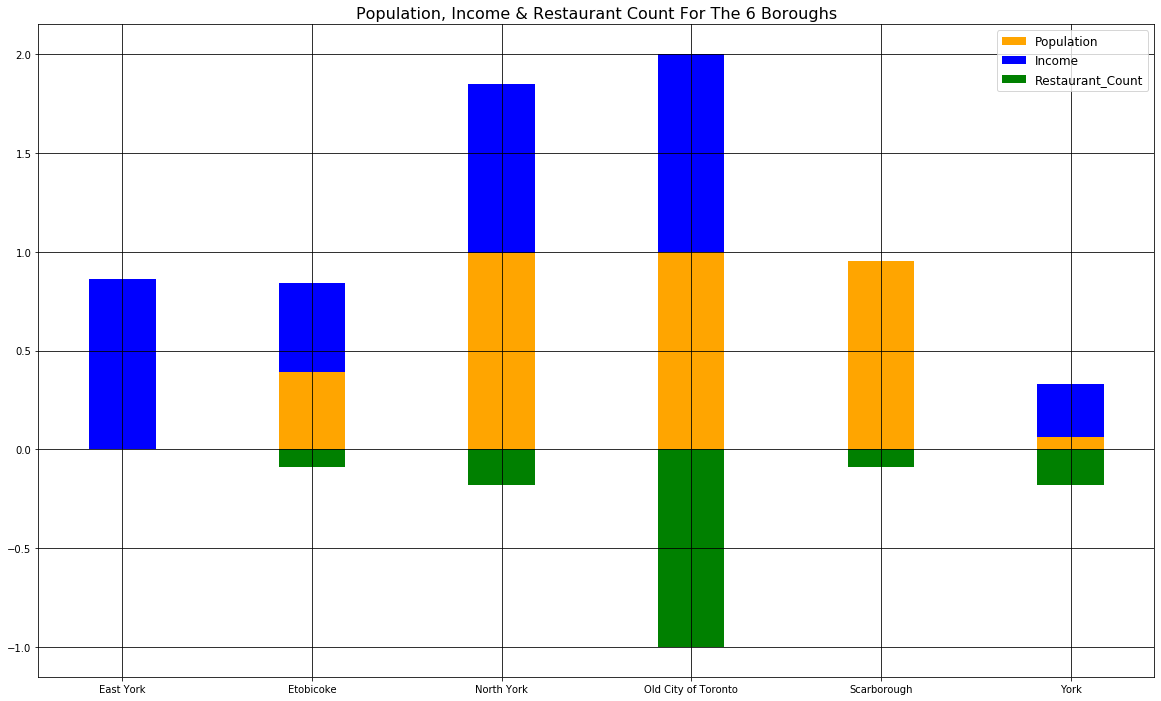

In [31]:
# Create the graph
plt.figure(figsize= (20,12))

# Create the x-axis labels
labels = ['East York', 'Etobicoke', 'North York', 'Old City of Toronto', 'Scarborough', 'York']

# Create 3 bars to hold the 3 factors
bars1 = df_norm['Population']
bars2 = df_norm['Income']
bars3 = -df_norm['Restaurant_Count']

# Set the width of the bars
width = 0.35

# Set the position of the bars on the x-axis
r = [0,1,2,3,4,5]

# Create base bars
plt.bar(r, bars1, color='orange', width=width, label='Population')
# Create the bars on top of the base bars
plt.bar(r, bars2, bottom=bars1, color='blue', width=width, label='Income')
# Create the bars below the x-axis
plt.bar(r, bars3, color='green', width=width, label='Restaurant_Count')

# Custom X axis
plt.xticks(r, labels)

# Draw the grid lines
plt.grid(True, color= 'k')

# Add the title, legend and x-tick labels
plt.title("Population, Income & Restaurant Count For The 6 Boroughs", fontsize= '16')
plt.rc('legend', fontsize= '12')
plt.rc('xtick', labelsize='14')
plt.legend()

# Plot the figure
plt.show()

#### A factor of zero for any of the boroughs in the above figure just meant that these boroughs had a relatively low value of that factor compared to the other boroughs since all factors were scaled between 0 and 1.

#### A new dataframe was created to store the total factor for each of the 6 boroughs. The results were then visualized in a graph.

In [32]:
# Create a new dataframe that contains the algebraic sum of the 3 factors after making the restaurant count negative
df_norm3= pd.DataFrame(columns=['Total_Factor'])

df_norm3['Total_Factor']= df_norm['Income']+df_norm['Population']-df_norm['Restaurant_Count']
df_norm3= pd.concat([df_norm['Borough'], df_norm3['Total_Factor'].round(2)], axis= 1)

# Set the index to Borough in order for the map to pick it up
df_norm3= df_norm3.set_index('Borough')

df_norm3

,Total_Factor
Borough,
East York,0.86
Etobicoke,0.75
North York,1.67
Old City of Toronto,1.00
Scarborough,0.86
York,0.15


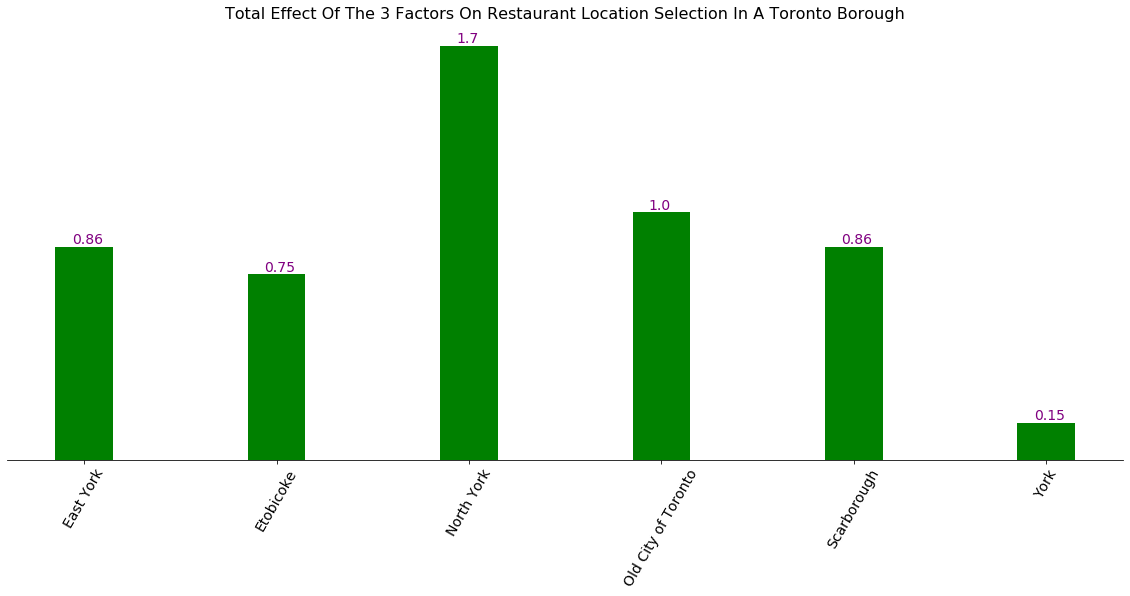

In [33]:
# Create the graph
ax = df_norm3.plot(kind='bar', width= 0.3, figsize=(20, 8), color=['green'])
ax = plt.gca()
ax.set_title('Total Effect Of The 3 Factors On Restaurant Location Selection In A Toronto Borough').set_fontsize('16')

# Remove the legend
ax.get_legend().remove()

# Set the x-tick label rotation and size  
for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(14)
    label.set_rotation(60)
    
# Retain only the bottom boundary of the figure  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_ticks([])

# Float the final numbers on top of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2}'.format(height), (x+0.085, y+height+0.01), color= 'purple', fontsize= 14)
    
# Drop the x- axis label
plt.xlabel('')

# Plot the figure
plt.show()

#### As shown in the above figure, North York had the highest total factor making it the best borough to host the restaurant. The analysis was drilled down to locate the best neighborhood in North York, for hosting the restaurant.

#### Since there were only 2 Indian restaurants in the borough, there was no need to perform K-means clustering. However, locations of the 2 restaurants could be visualized.

In [34]:
# Create a dataframe to hold the North York restaurant data
df_NY2= df_IR.loc[df_IR['Borough']== 'North York']
df_NY2= df_NY2.drop(columns=['Cluster Labels'])

df_NY2

,Restaurant_Name,Latitude,Longitude,Borough
1,Indian Crown,43.760076,-79.412153,North York
2,Butterchick Indian kitchen,43.762600,-79.410304,North York


#### The 2 restaurants were displayed on a map.

In [35]:
# Create a map that is centered at North York
map_york = folium.Map(location=[43.7615,-79.4111],zoom_start=13)

for lat,lng,neighborhood in zip(df_NY2['Latitude'],df_NY2['Longitude'],df_NY2['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_york)
    
map_york

#### The analysis was drilled down to the neighborhoods within the borough of North York. As shown above, the 2 Indian restaurants in North York were found to be close to each other. They were determined to be in the neighborhoods of Lansing and Willowdale. These neighborhoods were given a value of one for the Restaurant_Count and the rest were given a value of zero.

In [36]:
# Create 2 dataframes for holding the 3 factors pertaining to the neighborhoods of North York 
dfT3= dfT.loc[dfT['Borough']=='North York']
df_norm3=dfT3[['Population','Income']]
df_normR=pd.DataFrame(columns=['Restaurant_Count'])

# Scale all column values such that every value is between 0- 1
df_normC = (df_norm3 - df_norm3.min()) / (df_norm3.max() - df_norm3.min())

# Concatenate the 2 dataframes into one
df_norm4= pd.concat([dfT3['Neighborhood'], df_normC], axis=1)

df_norm4= df_norm4.reset_index(drop= True)

In [37]:
# Include Restaurant_Count in the dataframe
df_normR=pd.DataFrame(columns=['Restaurant_Count'])
df_norm4= pd.concat([df_norm4, df_normR], axis=1)

# Populate Restaurant_Count with 1 for Willowdale and Lansing and the rest of them with zero
df_norm4['Restaurant_Count']=0
df_norm4.loc[df_norm4['Neighborhood']=='Willowdale', 'Restaurant_Count']=1
df_norm4.loc[df_norm4['Neighborhood']=='Lansing', 'Restaurant_Count']=1

df_norm4

,Neighborhood,Population,Income,Restaurant_Count
0,Graydon Hall,0.068312,0.002261,0
1,Pelmo Park,0.061597,0.031951,0
2,Parkwoods,0.537912,0.041590,0
3,Parkway Forest,0.149754,0.005635,0
4,Henry Farm,0.026903,0.115656,0
5,Hillcrest,0.361298,0.036971,0
6,Hoggs Hollow,0.034070,0.685855,0
7,Willowdale,0.895422,0.059036,1
8,Bayview Woods – Steeles,0.253062,0.064492,0
9,Humber Summit,0.241612,0.011756,0


#### There were 40 neighborhoods in North York. Since plotting all of them on a graph would be unnecessary, the top 10 ordered by 'Total_Factor' were plotted.

In [38]:
# Create a new dataframe that contains the algebraic sum of the 3 factors
df_norm5= pd.DataFrame(columns=['Total_Factor'])

df_norm5['Total_Factor']= df_norm4['Income']+df_norm4['Population']- df_norm4['Restaurant_Count']
df_norm6= pd.concat([df_norm4['Neighborhood'], df_norm5['Total_Factor'].round(2)], axis= 1)

# Sort the dataframe in descending order of Sum_of_Factors
df_norm6= df_norm6.sort_values(by= 'Total_Factor', ascending= False)
df_norm6= df_norm6.set_index('Neighborhood')

# Select the boroughs with the top 10 highest Sum_of_Factors
df_norm7= df_norm6[0:10]

df_norm7

,Total_Factor
Neighborhood,
Bridle Path,1.00
Elia (Jane and Finch),1.00
Newtonbrook,0.78
Downsview,0.77
Hoggs Hollow,0.72
Don Valley Village,0.63
Parkwoods,0.58
York Mills,0.58
York University Heights,0.54


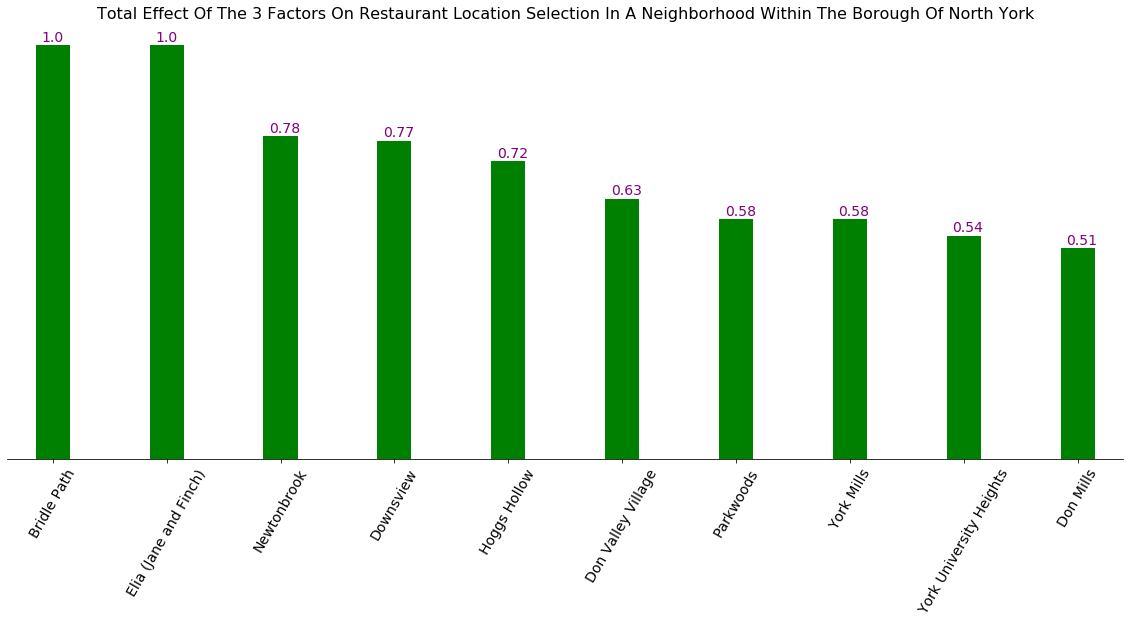

In [39]:
# Create the graph
ax = df_norm7.plot(kind='bar', width= 0.3, figsize=(20, 8), color=['green'])
ax = plt.gca()
ax.set_title('Total Effect Of The 3 Factors On Restaurant Location Selection In A Neighborhood Within The Borough Of North York').set_fontsize('16')

# Remove the legend
ax.get_legend().remove()

# Set the x-tick label rotation and size  
for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(14)
    label.set_rotation(60)
    
# Retain only the bottom boundary of the figure  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_ticks([])

# Float the final numbers on top of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2}'.format(height), (x+0.05, y+height+0.01), color= 'purple', fontsize= 14)
    
# Drop the x- axis label
plt.xlabel('')

# Plot the figure
plt.show()

## Results

#### K-means clustering grouped the restaurants into clusters that were comparable to the actual borough centers. <u>North York</u> was the best borough to host the Indian restaurant. The best neighborhoods, that were within North York, to host the new Indian restaurant were found to be <u>Bridle Path</u> and <u>Elia (Jane and Finch)</u>.

## Discussion

#### Five clusters were used for the K-means clustering since only 5 boroughs had Indian restaurants. The clustering process showed that the restaurants were not along the boundaries of the boroughs but around the centers.
#### According to this model, population and income were positive factors and restaurant count was a negative factor. The algebraic sum of the scaled 3 factors yielded the total factor. North York was the best borough to host the restaurant since it had the highest total factor. Since North York had only 2 Indian restaurants, K-means clustering in the borough was deemed unnecessary. After applying the 3 factors to the neighborhoods within North York, the top 2 neighborhoods that had the same score of 1 were Bridle Path and Elia (Jane and Finch). Hence, these 2 neighborhoods were deemed to be the best boroughs to host a new Indian restaurant. 
#### The results can be influenced by factors not considered in the model. Other factors could be added to this model like restaurant popularity, diversity index and land value. If there were many unpopular restaurants in the borough, it's possible that a new restaurant in that borough may still be a good idea since it may be able to beat out the competition and consume a majority of the demand. Diversity index, if available, could positively influence the location selection since an international population could be more inclined to going to international restaurants. A higher land value would increase the investment cost but that could be offset by an increase in demand for the new restaurant.
#### Land value could push Old City of Toronto, that was the second- best borough location, to be the best borough for the restaurant location, only if its land value was much lower than that of North York. If this was the case, since there were many Indian restaurants in Old City of Toronto, K-means clustering would need to be done for this borough and any neighborhood in this borough that is outside any of the clusters would be a good location for the restaurant. Staying outside of the clusters would mean the new restaurant would not compete with existing restaurants.

## Conclusion

#### Using the factors of population, income and restaurant count with the last factor being considered a negative influence, and allocating equal weight to the 3 factors, the best borough in Toronto to host a new Indian restaurant was <u>North York</u> and the best neighborhoods to host the restaurant would be <u>Bridle Path</u> and <u>Elia (Jane and Finch)</u>. Other factors not considered in the model like diversity index, restaurant popularity and land value could influence the model results. If including these factors moved the best borough to one that had several Indian restaurants, K-means clustering would need to be done for this borough, and any neighborhood outside any of the clusters would be the best neighborhood to start the restaurant.